# Theano Bukowski
On this notebook I improve the [Numpy Bukowski](https://github.com/masta-g3/summer_networks/tree/master/numpy_bukowski) poetry model by porting the code to Theano, which should perform much faster. Since the preprocessing section remains exactly the same, I start by loading the formatted dataset into memory.

In [9]:
## Import libaries.
import itertools
import theano
import theano.tensor as T
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
sns.set_style('whitegrid')

## Preprocessing

In [10]:
size = 10000
unknown_token = 'UNKNOWN_TOKEN'
start_symbol = 'START_SYMBOL'
stop_symbol = 'STOP_SYMBOL'

content = pd.read_pickle('data/content.pkl')

In [11]:
## Get word frequency.
sentences = [content.loc[i, 'tokens'] for i in content.index]
flattened = itertools.chain.from_iterable(sentences) 
word_freq = nltk.FreqDist(flattened)
print 'Found %d unique words tokens.' % len(word_freq.items())

Found 16271 unique words tokens.


In [12]:
## Limit vocabulary to most common words.
vocab = word_freq.most_common(size-1)
word_list = [x[0] for x in vocab]
word_list.append(unknown_token)
word_list
word_index = dict([(w,i) for i,w in enumerate(word_list)])

print 'Using vocabulary size %d.' % size
print "The least frequent word in our vocabulary is '%s' (%d appearance)." % (vocab[-1][0], vocab[-1][1])

Using vocabulary size 10000.
The least frequent word in our vocabulary is 'pandered' and appeared 1 times.


In [13]:
## Replace words not in dictionary with the unknown token.
for i, row in content.iterrows():
    for j, tkn in enumerate(row['tokens']):
        if tkn not in word_list:
            content.loc[i, 'tokens'][j] = unknown_token
            
print 'Sample processed poem:'
for index, row in content[content['poem'] == 1].iterrows():
    print ' '.join(row['tokens'])

Sample processed poem:
START_SYMBOL i awakened to dryness and the ferns were dead , STOP_SYMBOL
START_SYMBOL the potted plants yellow as corn ; STOP_SYMBOL
START_SYMBOL my woman was gone STOP_SYMBOL
START_SYMBOL and the empty bottles like bled corpses STOP_SYMBOL
START_SYMBOL surrounded me with their uselessness ; STOP_SYMBOL
START_SYMBOL the sun was still good , though , STOP_SYMBOL
START_SYMBOL and my landlady 's note cracked in fine and STOP_SYMBOL
START_SYMBOL undemanding UNKNOWN_TOKEN ; what was needed now STOP_SYMBOL
START_SYMBOL was a good comedian , ancient style , a UNKNOWN_TOKEN STOP_SYMBOL
START_SYMBOL with jokes upon absurd pain ; pain is absurd STOP_SYMBOL
START_SYMBOL because it exists , nothing more ; STOP_SYMBOL
START_SYMBOL i shaved carefully with an old razor STOP_SYMBOL
START_SYMBOL the man who had once been young and STOP_SYMBOL
START_SYMBOL said to have genius ; but STOP_SYMBOL
START_SYMBOL that 's the tragedy of the leaves , STOP_SYMBOL
START_SYMBOL the dead ferns

In [14]:
## Convert the info into training data.
X_train = np.asarray([[word_index[w] for w in sent[:-1]] for sent in content['tokens'].tolist()])
y_train = np.asarray([[word_index[w] for w in sent[1:]] for sent in content['tokens'].tolist()])

## Show an example.
x_example, y_example = X_train[49], y_train[49]
print 'Example Input data: ', 
input_sent = [word_list[i] for i in x_example]
print ' '.join(x for x in input_sent)

print 'Example Output data:', 
output_sent = [word_list[j] for j in y_example]
print ' '.join(x for x in output_sent)

Example Input data:  START_SYMBOL there is a UNKNOWN_TOKEN of some sort
Example Output data: there is a UNKNOWN_TOKEN of some sort STOP_SYMBOL


## Building the Network
Now that we have the data in the desired format, we start building the neural network. Our **RNNNumpy** class is made up by the following functions:

* *__init__* → Initializes parameters based on the number of word dimensions, hidden dimensions and random values taken from the uniform distribution $ \left[\dfrac{-1}{\sqrt{n}}, \dfrac{1}{\sqrt{n}}\right] $ for (U, V & W).

* *forward_propagation* → Generates the word probabilities by unfolding the neural network. Uses $tanh$ activation function for the input layer and $softmax$ for the output one.

* *predict* → Returns estimated output (i.e. the word with the highest probability of occuring next) from the forward propagation estimates.

* *calculate_loss* → Cross-entropy loss from prediction, as defined by the function below.

    $ L(y,o) = \dfrac{-1}{N} \sum y_n log(o_n)$

  
* *bptt* → Back-propagation algorithm, used to estimate gradients and update parameters.

* *sgd_step* → SGD to calculate gradients and perform updates in one batch.

In [15]:
class RNNTheano:
    
    def __init__(self, w_dim, h_dim=100, bptt_max=4):
        
        ## Set self parameters.
        self.w_dim = w_dim
        self.h_dim = h_dim
        self.bptt_max = bptt_max    
        
        ## Randomly initialize network parameters. Set to uniform between
        ## [-1/n, 1/n], where 'n' is the size of incoming connections.
        U = np.random.uniform(-np.sqrt(1./w_dim), np.sqrt(1./w_dim), (h_dim, w_dim))
        V = np.random.uniform(-np.sqrt(1./h_dim), np.sqrt(1./h_dim), (w_dim, h_dim))
        W = np.random.uniform(-np.sqrt(1./h_dim), np.sqrt(1./h_dim), (h_dim, h_dim))
        
        ## Assign to self as theano shared variables.
        self.U = theano.shared(name='U', value=U.astype(theano.config.floatX))
        self.V = theano.shared(name='U', value=V.astype(theano.config.floatX))
        self.W = theano.shared(name='W', value=W.astype(theano.config.floatX))
        
        ## Build Model.
        self.theano = {}
        self.build_model()
    
    def build_model(self):
        
        ## Define parameters.
        x = T.ivector('x')
        y = T.ivector('y')
        U, V, W = self.U, self.V, self.W
        
        ## Forward propagation to perform at each step.
        def fwd_step(x_t, s_t_prev, U, V, W):
            s_t = T.tanh(U[:,x_t] + W.dot(s_t_prev))
            o_t = T.nnet.softmax(V.dot(s_t))
            ## Softmax returns a matrix, so we convert it into a vector.
            return [o_t[0], s_t]
        
        ## Iterate over all observations
        [o,s], updates = theano.scan(fwd_step,
                                     sequences=x,
                                     outputs_info=[None, dict(initial = T.zeros(self.h_dim))],
                                     non_sequences=[U,V,W],
                                     truncate_gradient=self.bptt_max,
                                     strict=True)
        
        ## Prediction and loss.
        predict = T.argmax(o, axis=1)
        o_error = T.sum(T.nnet.categorical_crossentropy(o, y))
        
        ## Define gradients.
        dU = T.grad(o_error, U)
        dV = T.grad(o_error, V)
        dW = T.grad(o_error, W)
        
        ## Convert graph into actual functions.
        self.fwd_prop = theano.function([x], o)
        self.predict = theano.function([x], predict)
        self.ce_error = theano.function([x,y], o_error)
        self.bptt = theano.function([x,y], [dU, dV, dW])
    
        ## SGD.
        l_rate = T.scalar('l_rate')
        self.sgd_step = theano.function([x,y,l_rate], [],
                                        updates = [(U, U - l_rate * dU),
                                                   (V, V - l_rate * dV),
                                                   (W, W - l_rate * dW)])
    
    ## Total loss function...
    def total_loss_function(self, X, Y):
        return np.sum([self.ce_error(x, y) for x,y in zip(X,Y)])
        
    ## Loss by words.
    def loss_function(self, X, Y):
        n = np.sum([len(y) for y in Y])
        return self.total_loss_function(X, Y) / float(n)

In [16]:
def train_with_sgd(model, X_train, y_train, l_rate=0.005, epochs=100, evaluate_loss_after=5):
    ## List to keep track of losses.
    losses = []
    examples_seen = 0
    
    for epoch in range(epochs):
        if(epoch % evaluate_loss_after == 0):
            loss = model.loss_function(X_train, y_train)
            losses.append((examples_seen, loss))
            time = datetime.now().strftime('%H:%M:%S')
            print '%s: Loss after num_examples=%d & epoch=%d: %f.' %(time, examples_seen, epoch, loss)
            
            ## Adjust learning rate if loss increases.
            if(len(losses) > 1 and losses[-1][1] > losses[-2][1]):
                l_rate = l_rate * 0.5
                print 'Updating learning rate to %f.' %l_rate
            
        ## Save model parameters
        #save_model_parameters_theano('./data/rnn-theano-%d-%d-%s.npz' % (model.h_din, model.w_dim, time), model)
        
        ## For each training example...
        for i in range(len(y_train)):
            ## do one SGD step.
            model.sgd_step(X_train[i], y_train[i], l_rate)
            examples_seen += 1
    
    return losses

## Training the Model

In [17]:
## Create model with theano.
model = RNNTheano(size)

In [ ]:
## Verify that indeed the algorithm reduces the error over time.
losses = train_with_sgd(model, X_train, y_train, l_rate=0.000003, epochs=10, evaluate_loss_after=1)

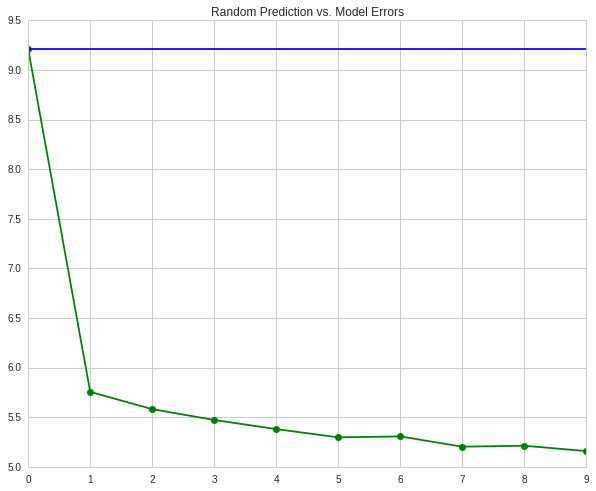

In [19]:
plt.plot([l[1] for l in losses], 'go')
plt.plot([l[1] for l in losses], 'g-')
plt.axhline(np.log(size))
plt.title('Random Prediction vs. Model Errors')

## Generating Sentences
We can use this generative model to create new sentences that have the highest probability of looking like Bukowski's. The longer we train the network, the better looking sentences the algorithm generates.

In [36]:
def generate_sentence(model):
    # All sentences begin with START_SYMBOL.
    new_sentence = [word_index[start_symbol]]
    # And end with STOP_SYMBOL.
    while not new_sentence[-1] == word_index[stop_symbol]:
        next_word_prob = model.fwd_prop(new_sentence)
        sampled_word = word_index[unknown_token]
        # We don't want to sample unknown words
        while sampled_word == word_index[unknown_token]:
            samples = np.random.multinomial(1, next_word_prob[-1])
            sampled_word = np.argmax(samples)
        new_sentence.append(sampled_word)
    sentence_str = [word_list[x] for x in new_sentence[1:-1]]
    return sentence_str

num_sentences = 10
min_length = 4

for i in range(num_sentences):
    sent = []
    # We want long sentences, not sentences with one or two words
    while len(sent) < min_length:
        sent = generate_sentence(model)
    print ' '.join(sent)

all killed a half old motel sees up the chairs
was burn to checkers
on your antelope ,
a great bad slippers ! ho
and their paper comes !
germans a homo room .
typewriter the time .
queer both , the thin said somewhere on so
passing your ought , i
without join market the tuesday
